In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import itertools as it
from glob import glob
from matplotlib import pyplot as plt
from pymea import plotting
from pymea import matlab_compatibility as mc

In [3]:
data_path = '/media/sam/hdd1/maestro_recordings/002/002_spike_frequency.csv'
data_table = pd.read_csv(data_path)
time_vector = data_table['time'].map(mc.datetime_str_to_datetime)

In [4]:
data_table.columns

Index([u'A1111', u'B1111', u'C1111', u'D1111', u'E1111', u'F2111', u'A3111',
       u'B3111', u'C3111', u'D3111',
       ...
       u'D7441', u'E7441', u'F7441', u'A8441', u'B8441', u'C8441', u'D8441',
       u'E8441', u'F8441', u'time'],
      dtype='object', length=685)

In [5]:
well_assignments = {
    'dtx 100 nM': ((1, 1), (1, 2), (1, 3)),
    'dtx 10 nM': ((2, 1), (2, 2), (2, 3)),
    'dtx 1 nM': ((3, 1), (3, 2), (3, 3)),
    'ba 2.5 mM': ((4, 1), (4, 2), (4, 3)),
    'ba 0.5 mM': ((5, 1), (5, 2), (5, 3)),
    'ba 0.1 mM': ((6, 1), (6, 2), (6, 3)),
    'bicc 20 uM': ((1, 4), (1, 5)),
    'bicc 2 uM': ((2, 4), (2, 5)),
    'ctrl': ((3, 4), (4, 4), (3, 5), (4, 5)),
    'dmso': ((5, 4), (5, 5)),
    'actinomycin_d': ((6, 4), (6, 5)),
    'ptx 100 uM': ((1, 6), (2, 6)),
    'ptx 10 uM': ((1, 7), (2, 7)),
    'ptx 1 uM': ((1, 8), (2, 8)),
    'xe 1 uM': ((3, 6), (3, 7), (3, 8)),
    'xe 100 nM': ((4, 6), (4, 7), (4, 8)),
    'kcl 5 mM': ((5, 6), (6, 6)),
    'kcl 1 mM': ((5, 7), (6, 7)),
    'kcl 0.1 mM': ((5, 8), (6, 8))
}

def create_well_assignment_filter(cond_name):
    def well_assignment_filter(col_name):
        row_col_tuple = mc.get_row_col_number_tuple(col_name)
        return row_col_tuple in well_assignments[cond_name]
    return well_assignment_filter

def create_filter_dict(key_iter):
    return {
        cond_name: create_well_assignment_filter(cond_name) 
            for cond_name in key_iter 
    }

condition_filter_dict = create_filter_dict(well_assignments.iterkeys()) 

super_conditions = {
    'dtx': ('dtx 100 nM', 'dtx 10 nM', 'dtx 1 nM'),
    'ba': ('ba 2.5 mM', 'ba 0.5 mM', 'ba 0.1 mM'),
    'bicc': ('bicc 20 uM', 'bicc 2 uM'),
    'ctrl': ('ctrl'),
    'dmso': ('dmso'),
    'actinomycin_d': ('actinomycin_d'),
    'ptx': ('ptx 100 uM', 'ptx 10 uM', 'ptx 1 uM'),
    'xe': ('xe 1 uM', 'xe 100 nM'),
    'kcl': ('kcl 5 mM', 'kcl 1 mM', 'kcl 0.1 mM')
}

super_cond_filter_dicts = {
    super_cond: create_filter_dict(sub_conds) for super_cond, sub_conds in super_conditions.iteritems()
}

In [6]:
cat_table = plotting.construct_categorized_dataframe(data_table, condition_filter_dict)
cat_table['spike_freq'] = cat_table['spike_freq']/300 # convert from spikes/five minutes to spikes/second
cat_table['spike_freq'] = plotting.smooth(cat_table['spike_freq'], kernel_size=4) # smooth using a 20 minute kernel
cat_table.to_csv('002_categorized_spike_counts.csv')

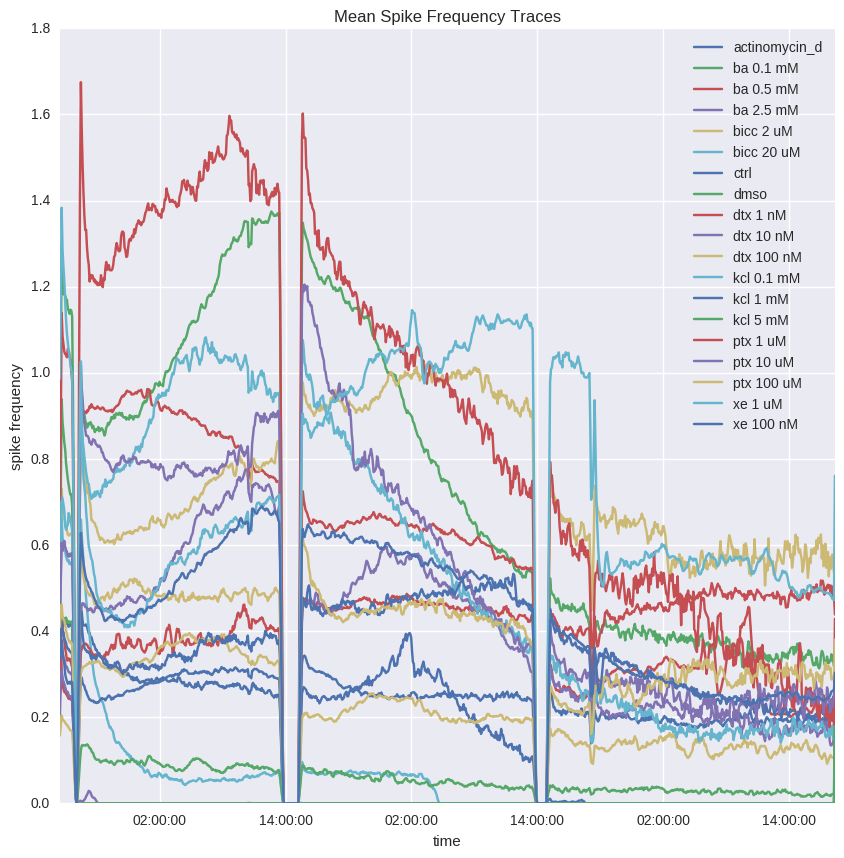

In [ ]:
plt.figure(figsize=(10, 10))
plotting.plot_mean_frequency_traces(cat_table)

/home/sam/anaconda2/lib/python2.7/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


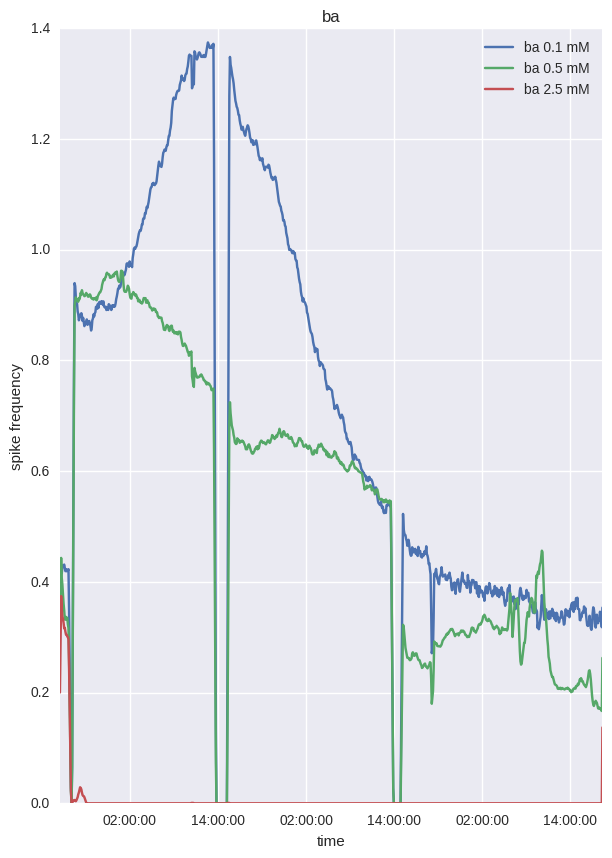

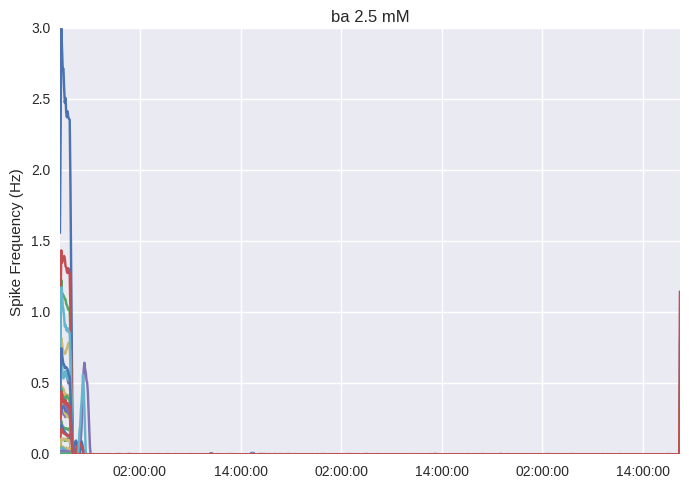

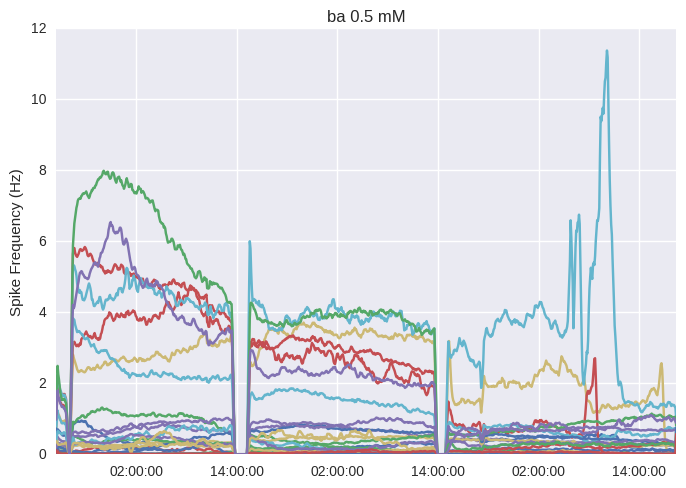

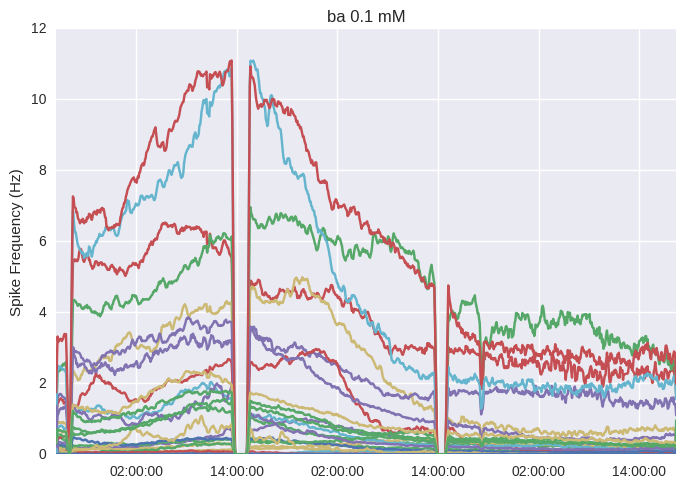

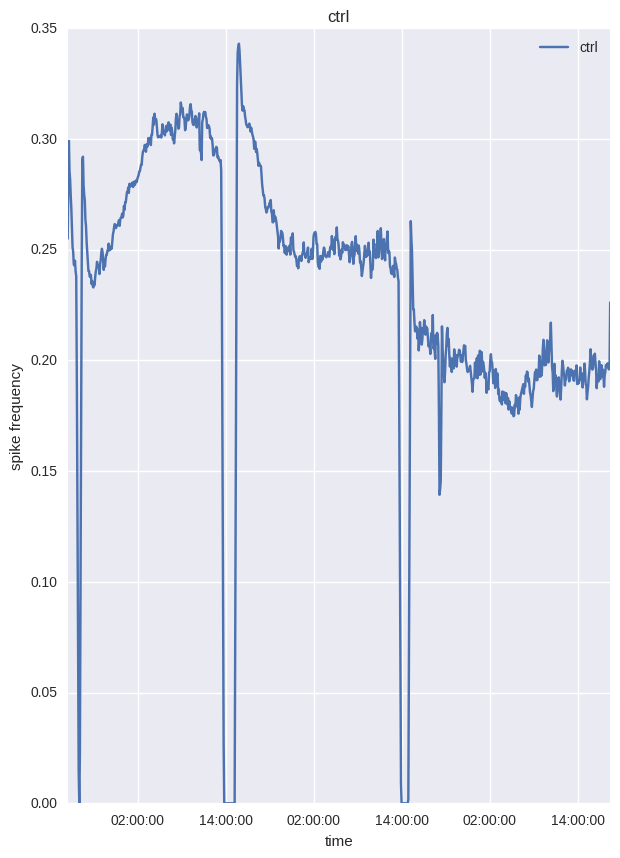

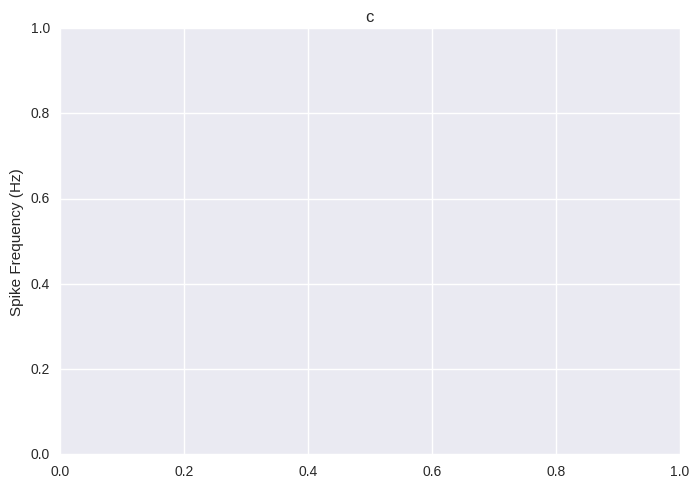

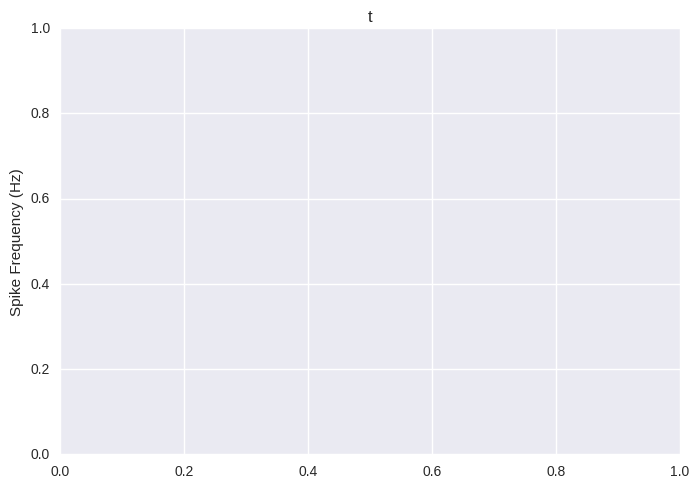

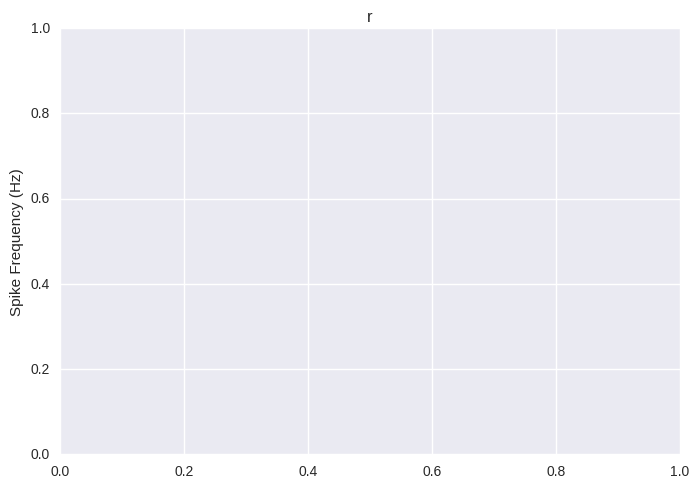

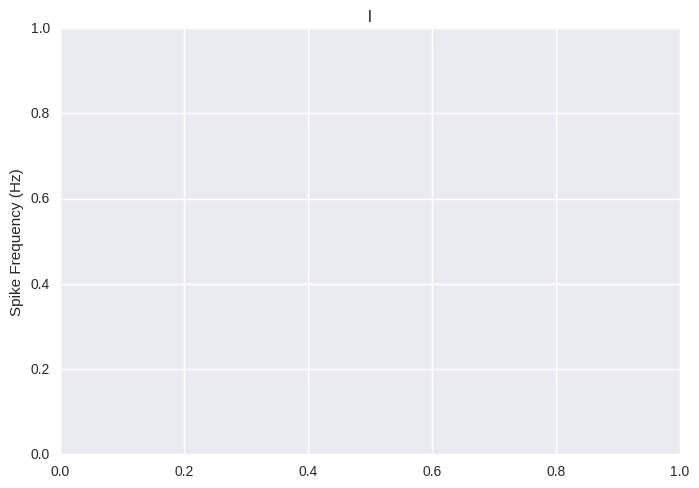

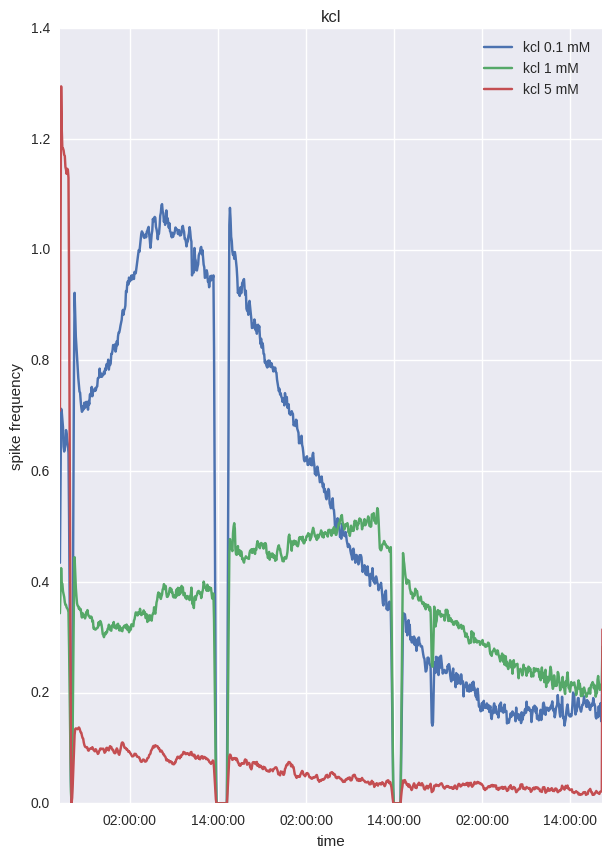

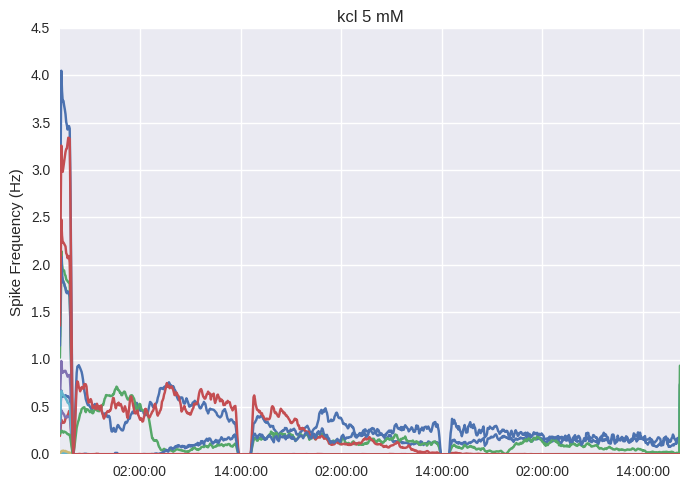

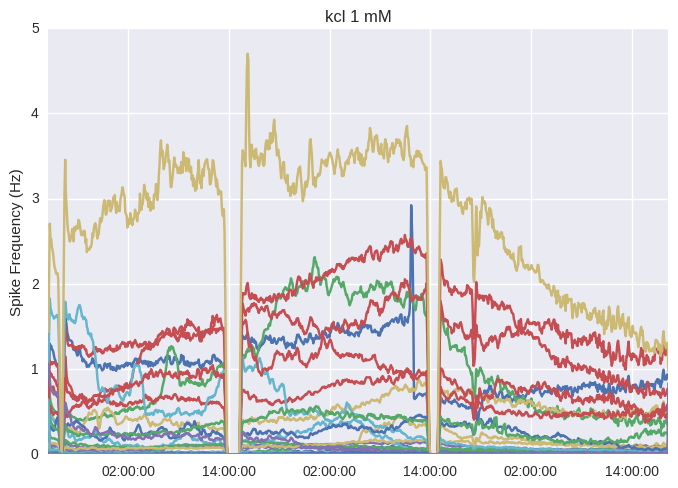

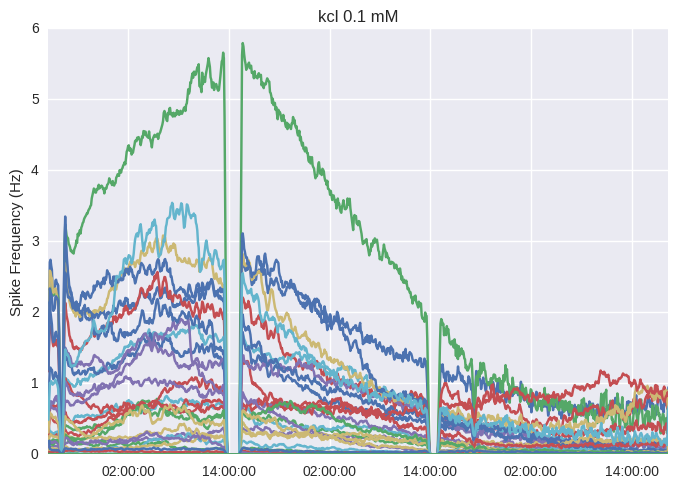

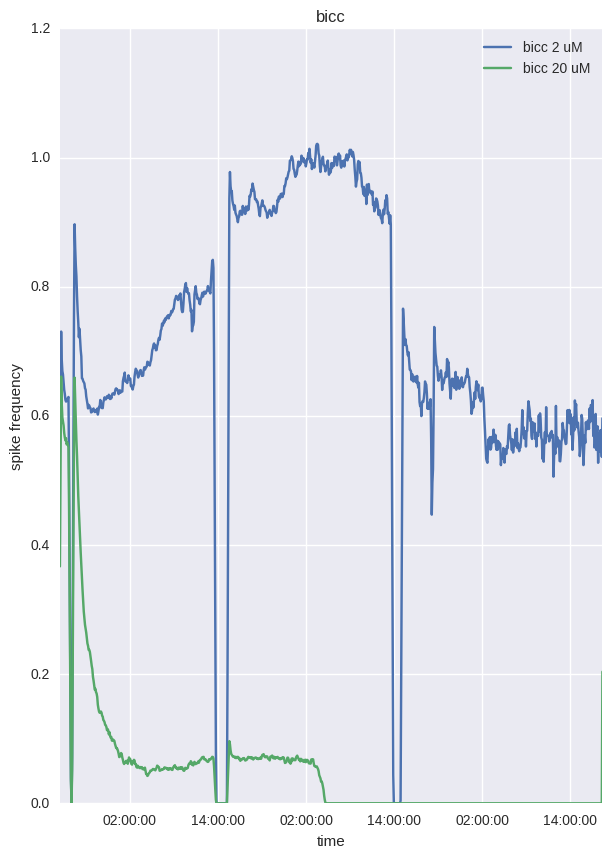

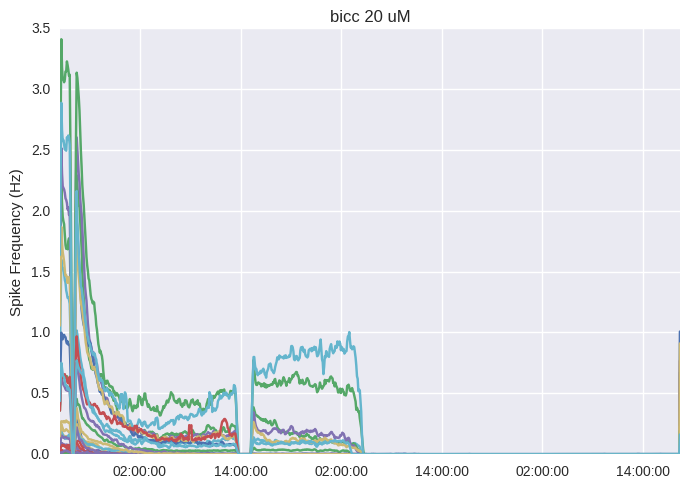

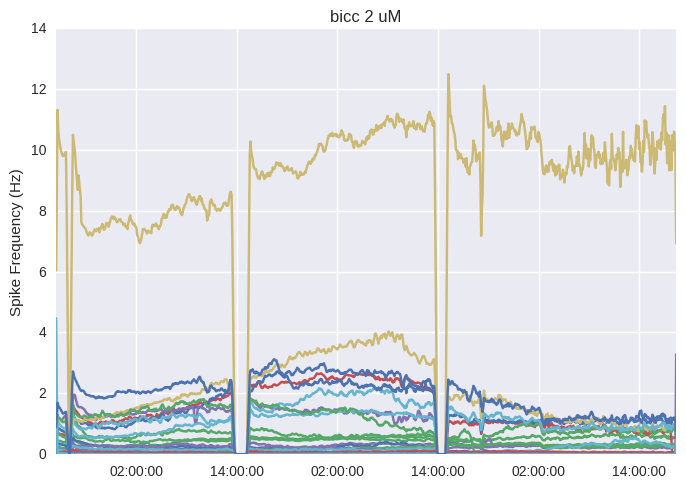

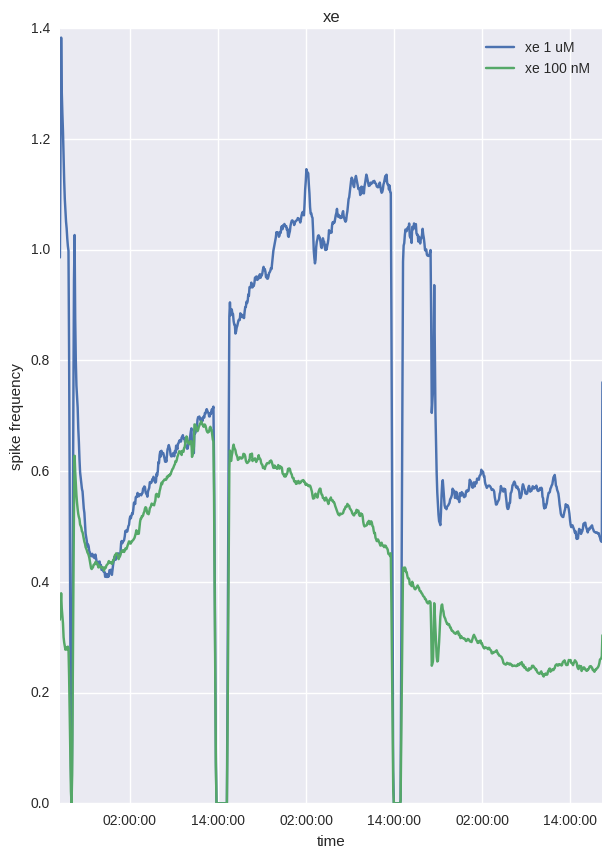

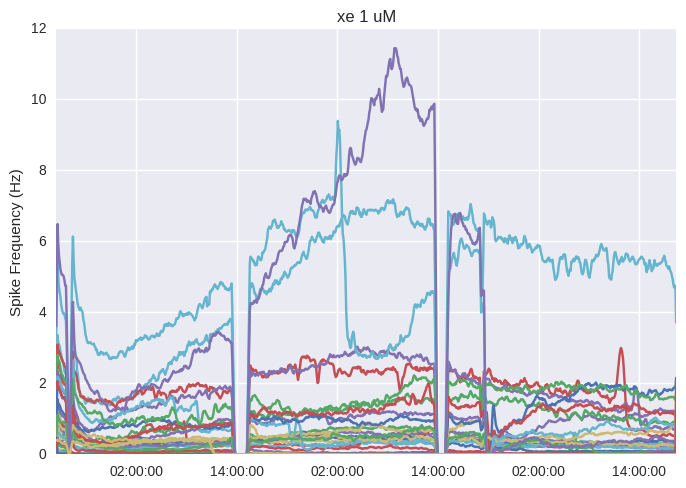

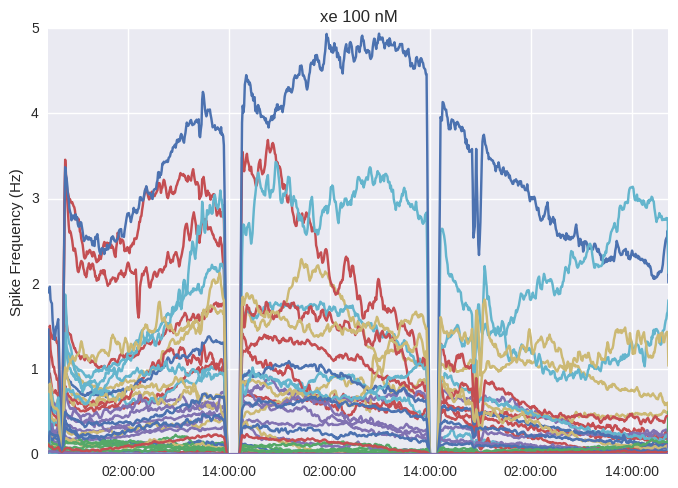

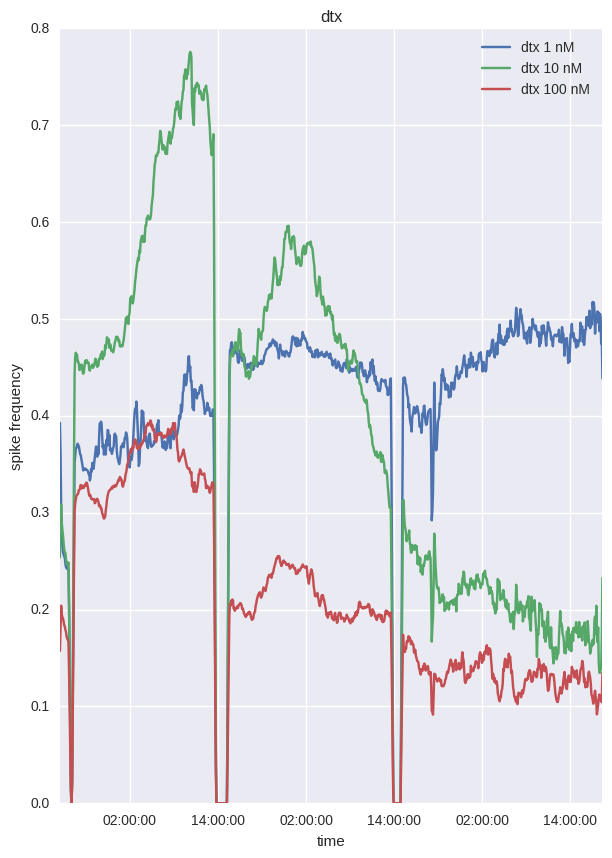

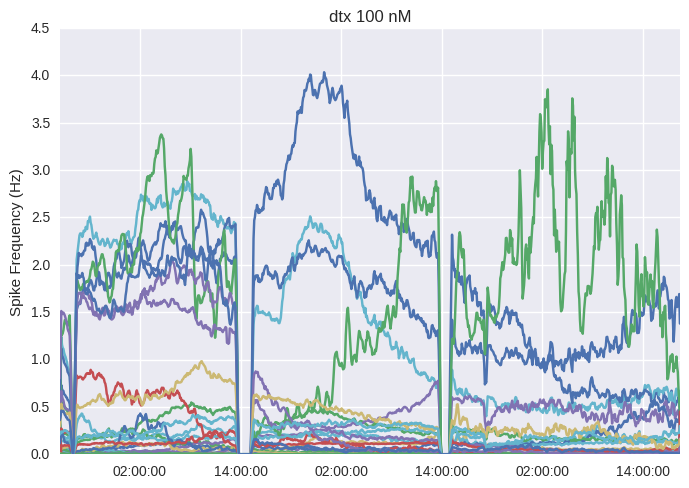

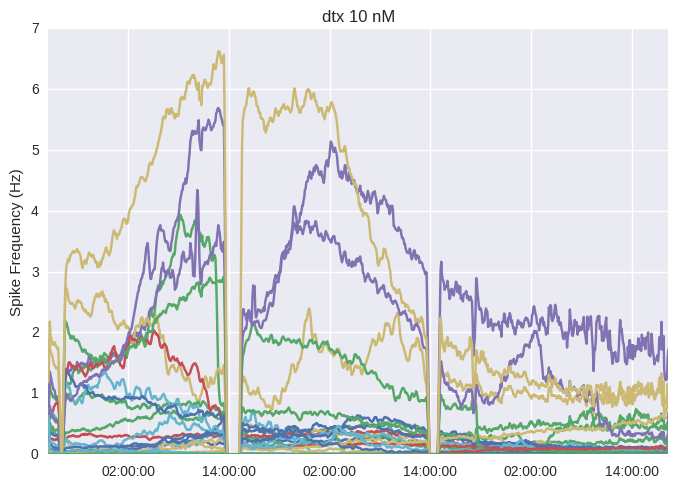

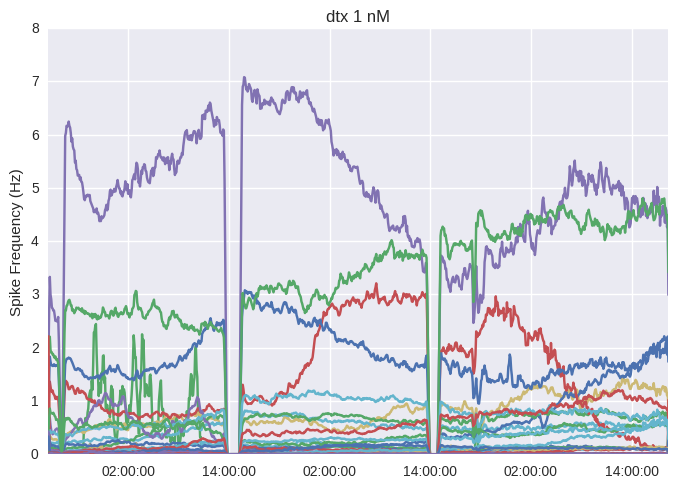

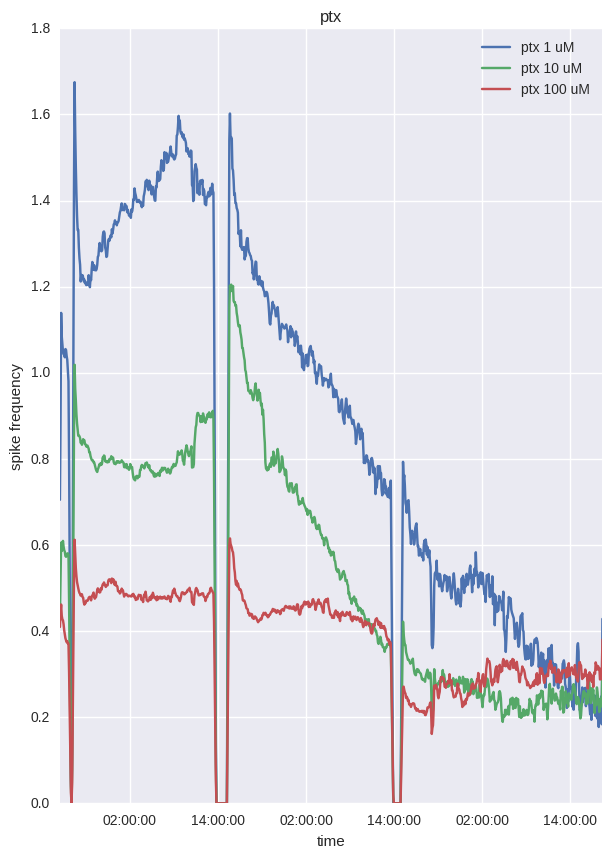

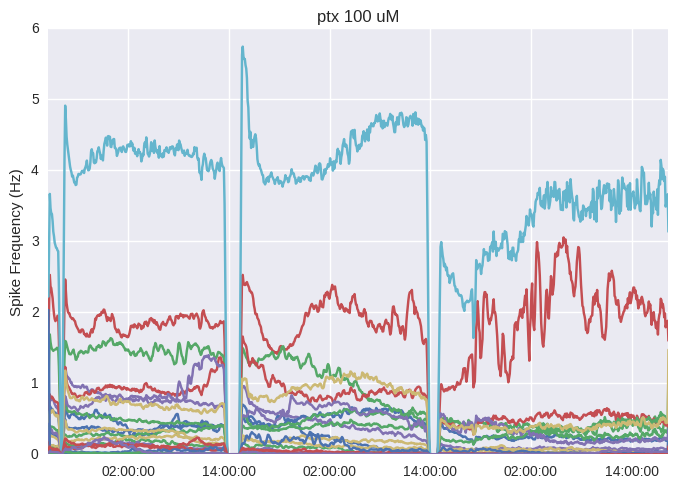

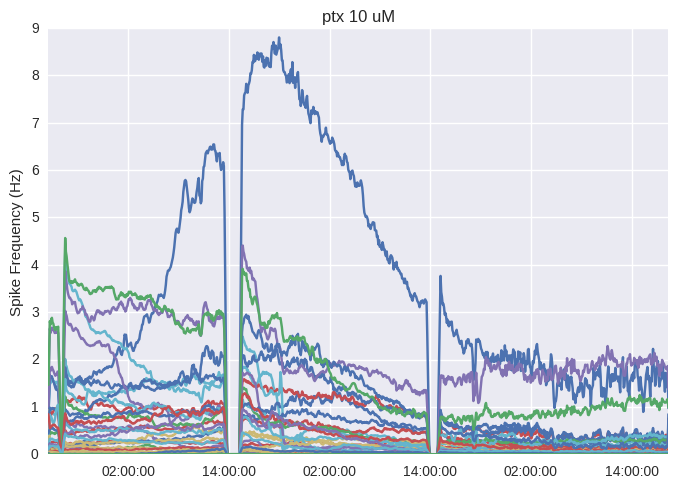

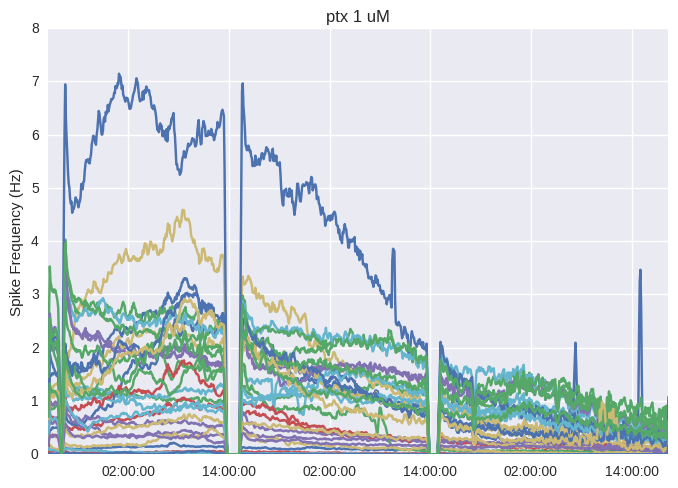

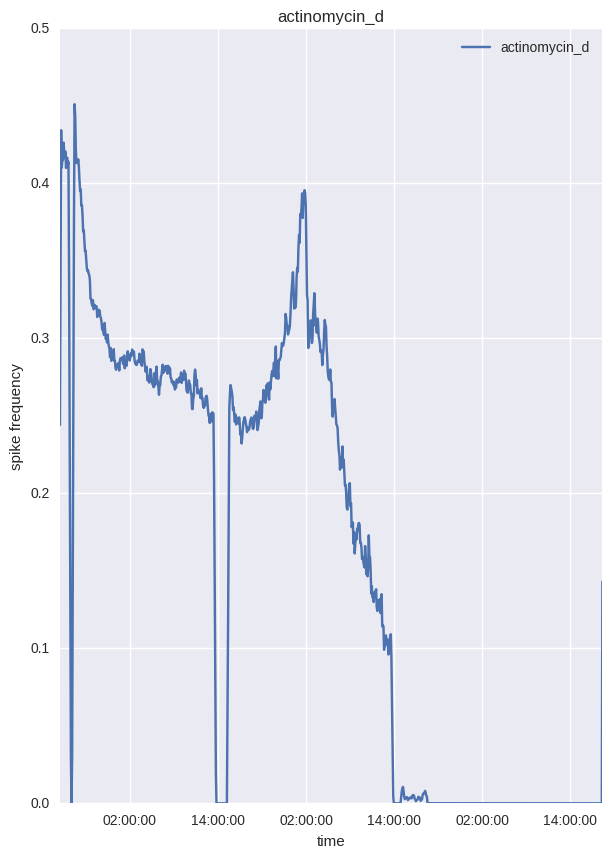

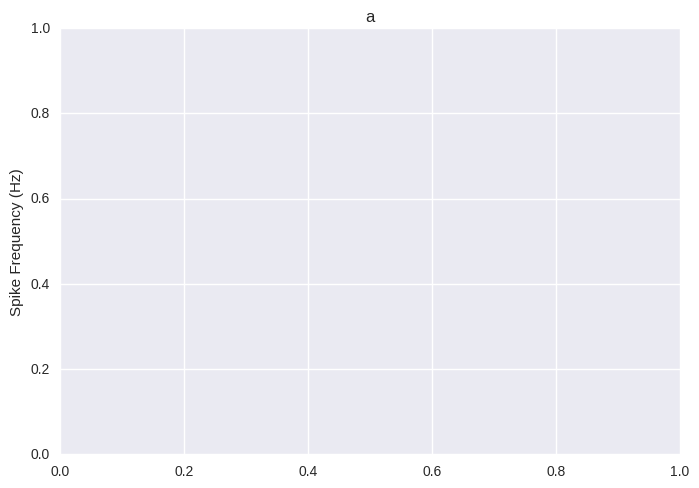

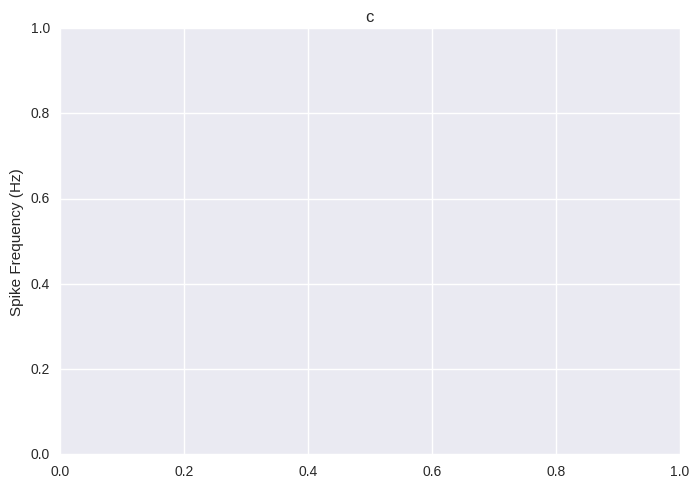

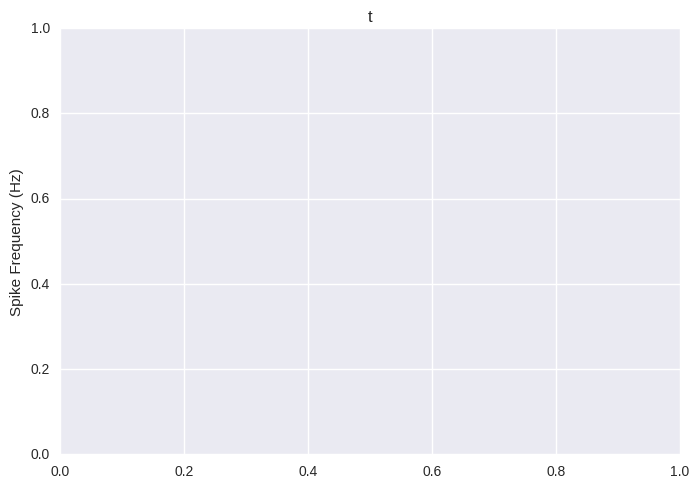

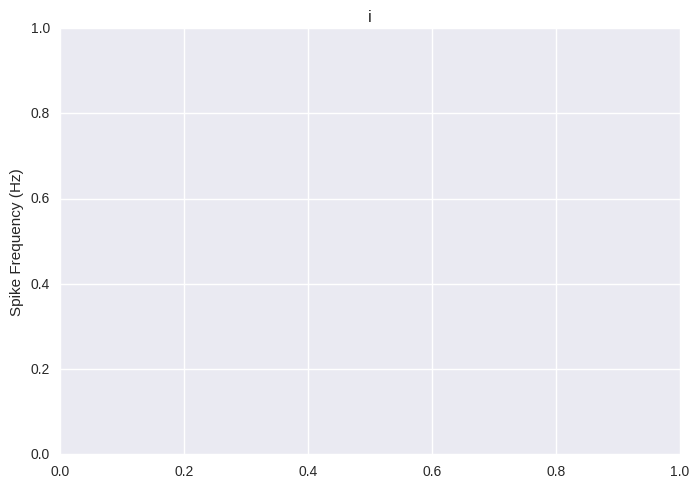

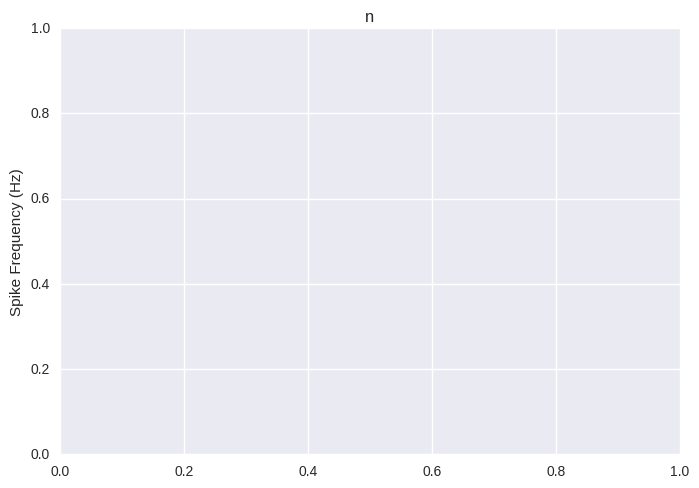

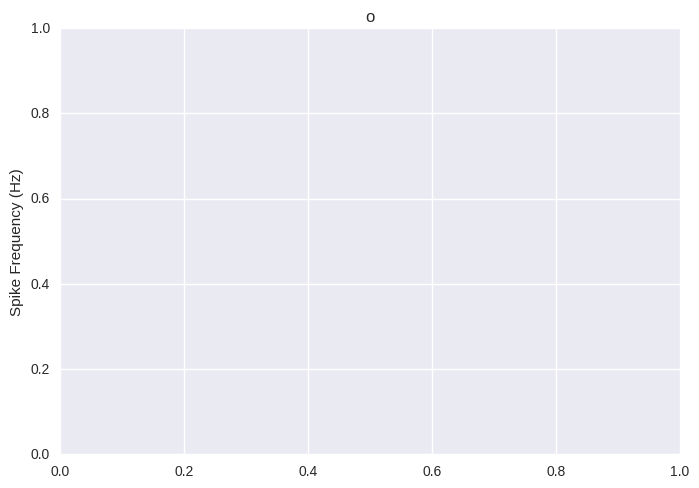

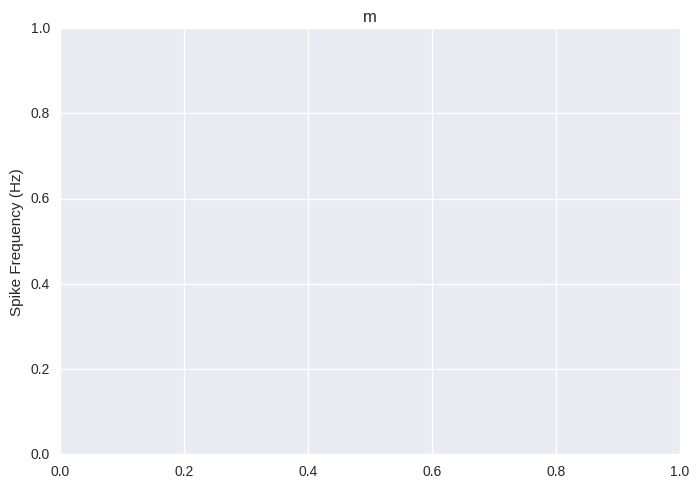

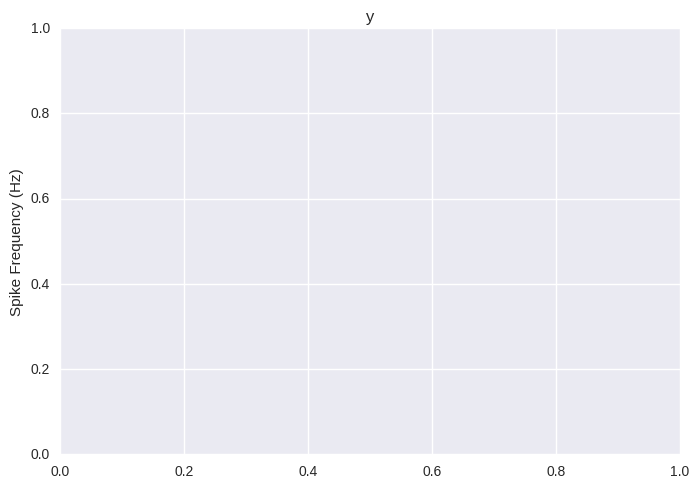

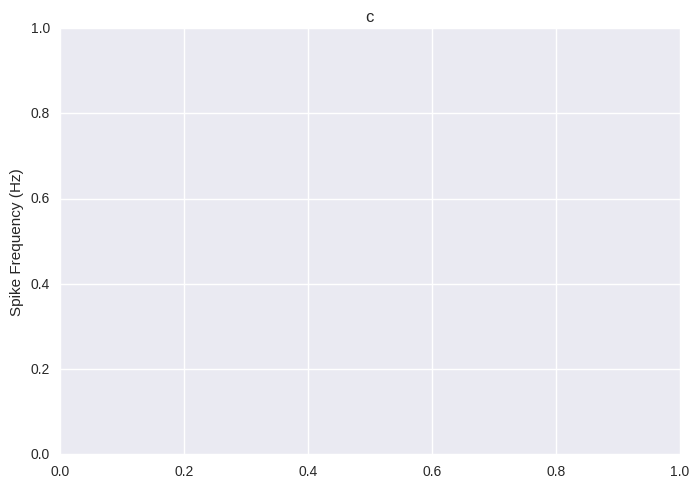

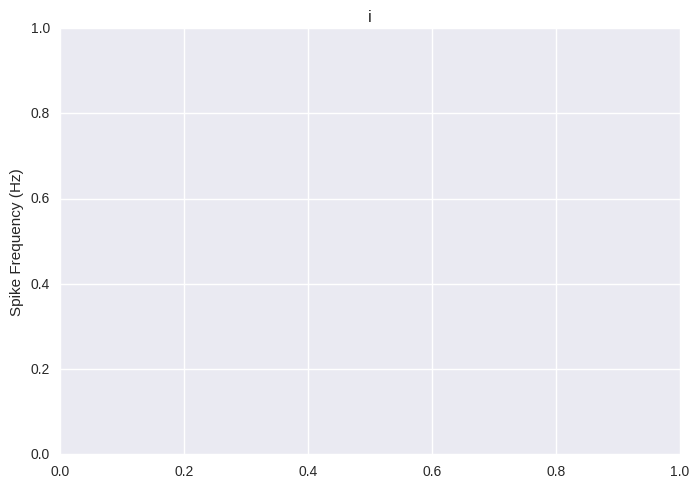

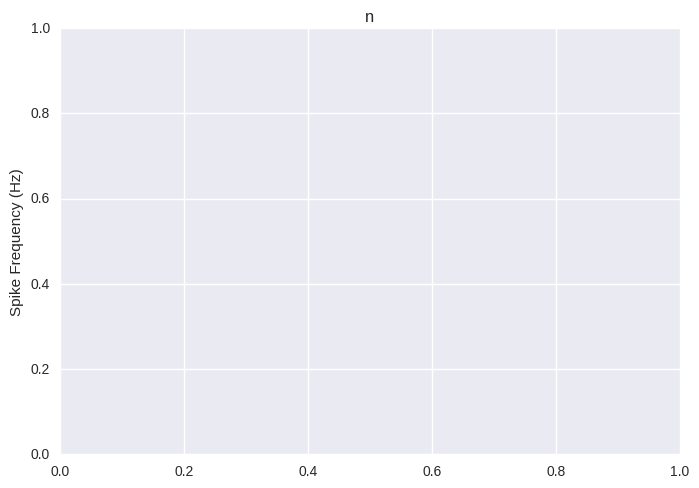

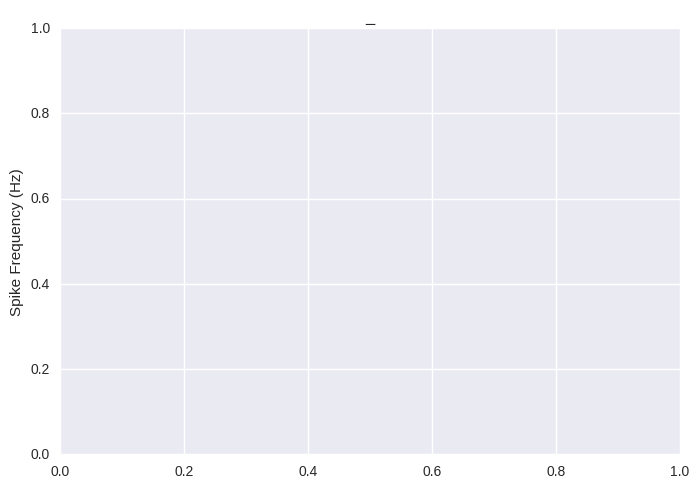

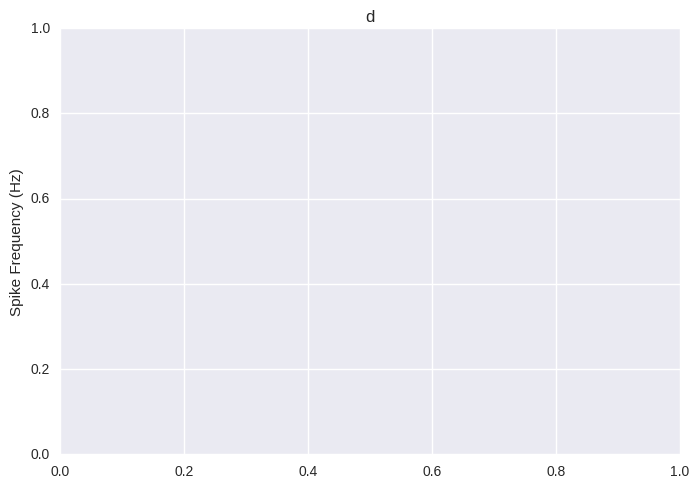

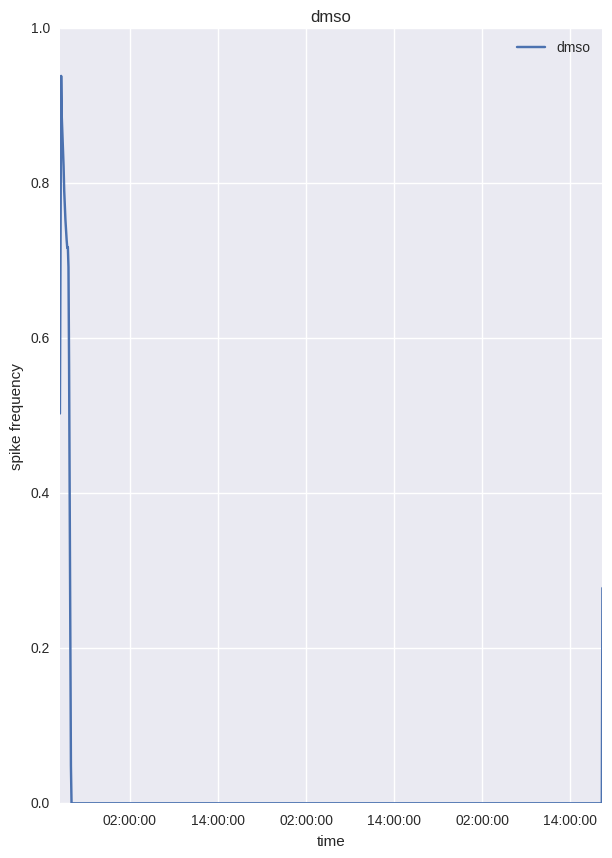

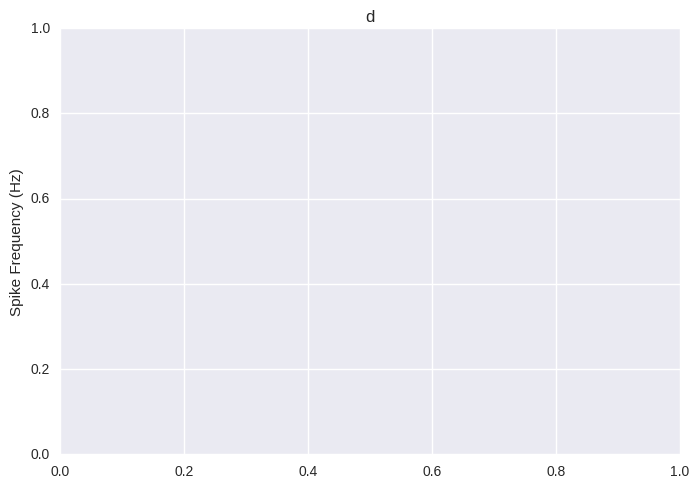

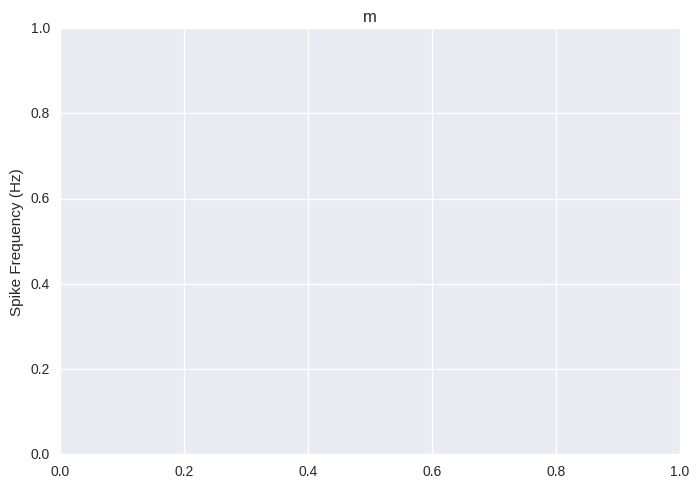

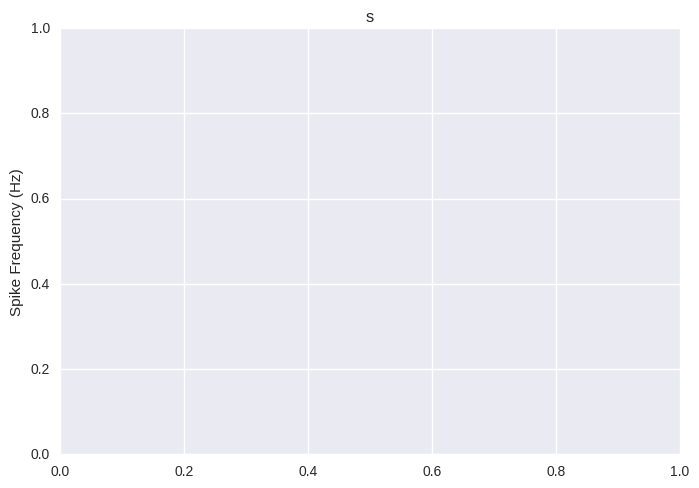

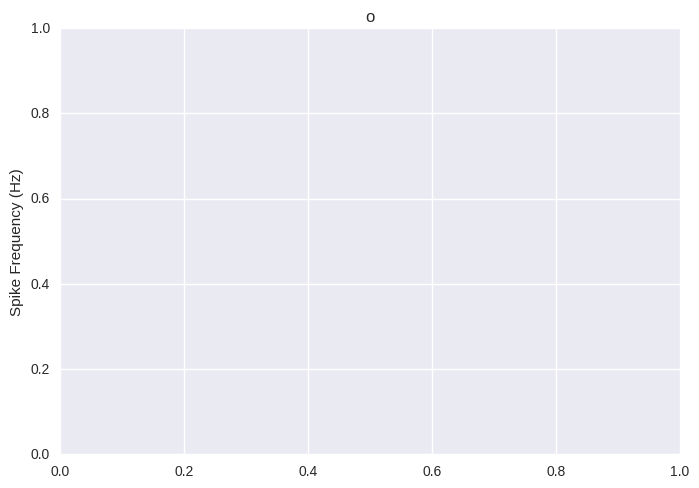

In [ ]:
super_cat_tables = {super_cat: cat_table.query('condition in @sub_cats') for super_cat, sub_cats in super_conditions.iteritems()}
for super_cat, sub_cat_table in super_cat_tables.iteritems():
    plt.figure(figsize=(7, 10))
    plotting.plot_mean_frequency_traces(sub_cat_table)
    plt.title(super_cat)
    for condition in super_conditions[super_cat]:
        cond_table = cat_table.query('condition == @condition')
        plt.figure()
        plotting.plot_unit_traces(cond_table)
        plt.ylabel('Spike Frequency (Hz)')
        plt.title(condition)
        